## Analyse the data and see the relationship between each features (EDA)
+ Analyse the relationship between features and income base on location
+ Check the distribution of the data

+ importing libraries and data

In [1]:
import os
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.10"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3.10"

In [2]:
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, hour, avg

spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/28 02:10:19 WARN Utils: Your hostname, TRANG, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/28 02:10:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/28 02:10:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
taxi_df = spark.read.parquet('data/processed_data/nyc_taxi_final.parquet/')
weather_df = spark.read.parquet('data/processed_data/processed_weather_data.parquet')

In [4]:
weather_df.show(5, truncate=False)

+----------+----------+--------+----------------+-----------------+------------+---------+---------------+
|timestamp |date      |time    |air_temp_celsius|dew_point_celsius|air_pressure|precip_mm|precip_happened|
+----------+----------+--------+----------------+-----------------+------------+---------+---------------+
|2025-01-01|2025-01-01|00:51:00|8.9             |3.9              |1005.2      |0.0      |N              |
|2025-01-01|2025-01-01|01:51:00|7.2             |5.0              |1003.2      |1.3      |Y              |
|2025-01-01|2025-01-01|02:46:00|7.0             |5.0              |9999.9      |1.7      |Y              |
|2025-01-01|2025-01-01|02:47:00|7.2             |5.0              |1001.8      |3.6      |Y              |
|2025-01-01|2025-01-01|02:56:00|6.7             |5.0              |9999.9      |2.0      |Y              |
+----------+----------+--------+----------------+-----------------+------------+---------+---------------+
only showing top 5 rows


### 1. Effect distribution of taxi trips tips and income throught out the day 
+ using pickup date-time
+ income disregard the tips 
+ when checking tips, exclude cash tips

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Extract hour from pickup_datetime for time-based analysis
taxi_df_time = taxi_df.withColumn("hour", hour(col("pickup_datetime")))
print("Shape after extract the hour from pickup time:", 
      (taxi_df_time.count(), len(taxi_df_time.columns)))

# Aggregate average fare by hour
hourly_stat = (
    taxi_df_time
    .groupBy("hour")
    .agg(avg("fare_amount").alias("avg_fare_amount"))
    .orderBy("hour")
)
print("Shape after aggregate average fare by hour:", 
      (hourly_stat.count(), len(hourly_stat.columns)))


Shape after extract the hour from pickup time: (28508957, 8)


Shape after aggregate average fare by hour: (24, 2)


In [6]:
hourly_stat_pd = hourly_stat.toPandas() 

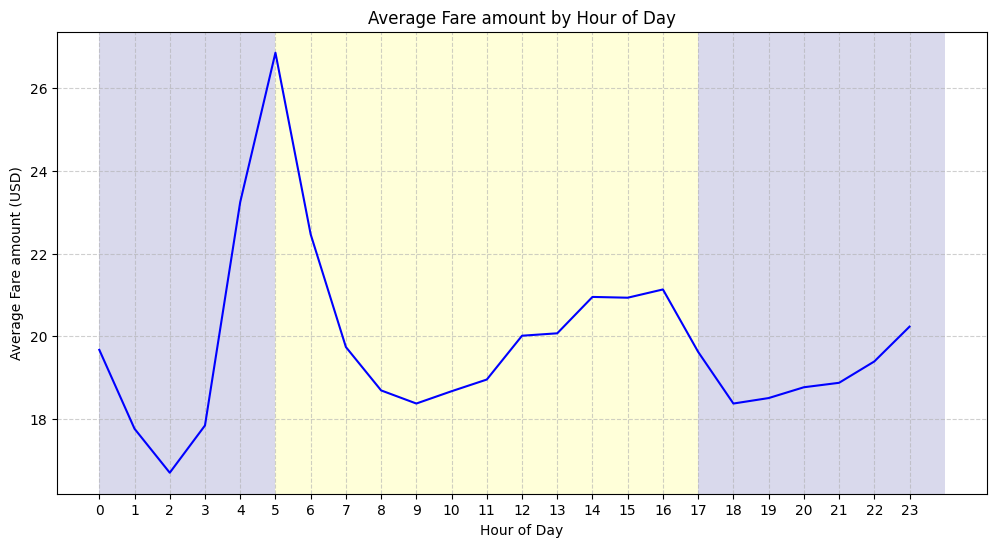

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="avg_fare_amount", data=hourly_stat_pd, color="blue")
plt.xticks(range(0, 24))
# Highlight background for day (5 AM – 17 PM) and night
plt.axvspan(0, 5, facecolor="navy", alpha=0.15)      # Night before morning
plt.axvspan(5, 17, facecolor="yellow", alpha=0.15)   # Daytime
plt.axvspan(17, 24, facecolor="navy", alpha=0.15)    # Night after evening
plt.title("Average Fare amount by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare amount (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_fare_by_hour.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
# extracting the date from the pickup datetime
# We want to give the driver data for when they should start working
taxi_df_date = taxi_df.withColumn(
    "date", col("pickup_datetime").cast("date")
)
print("Shape after extract the date from pickup datetieme:", 
      (taxi_df_date.count(), len(taxi_df_date.columns)))

Shape after extract the date from pickup datetieme: (28508957, 8)


Seasonal weather reference: https://www.newyork.com.au/travel-season-new-york/#:~:text=Winter:%20December%20to%20March,Autumn:%20September%20to%20December

How I choose color: https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py

In [8]:
## Check distribution of tips and income by date
daily_stat = taxi_df_date.groupBy("date")\
    .agg({"fare_amount": "avg"})\
    .withColumnRenamed("avg(fare_amount)", "avg_fare_amount")

daily_stat_pd = daily_stat.toPandas()

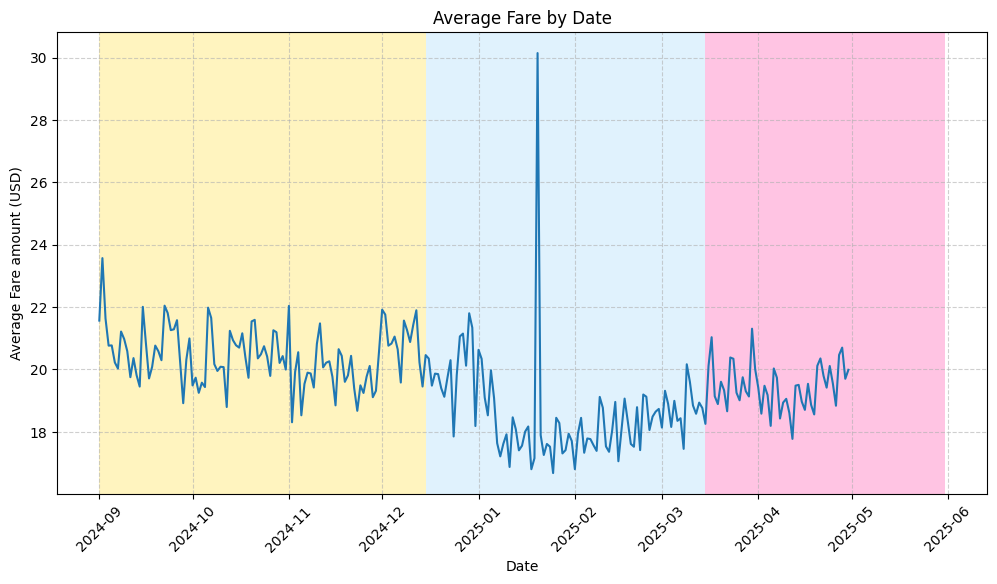

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="avg_fare_amount", data=daily_stat_pd)
plt.xticks(rotation=45)

# Highlight background for seasonal patterns 2024 2025
plt.axvspan(datetime(2024, 9, 1), datetime(2024, 12, 15), facecolor="gold", alpha=0.25)  # Autumn
plt.axvspan(datetime(2024, 12, 15), datetime(2025, 3, 15), facecolor="lightskyblue", alpha=0.25)  # Winter
plt.axvspan(datetime(2025, 3, 15), datetime(2025, 5, 31), facecolor="deeppink", alpha=0.25)  # Spring

plt.title("Average Fare by Date")
plt.xlabel("Date")
plt.ylabel("Average Fare amount (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_fare_by_date.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
## Checking the distribution of tips throughout the day
# Only consider tips that are not cash tips
from pyspark.sql.functions import col, hour

# Filter for cash payments (payment_type = "1")
taxi_df_tips = taxi_df.filter(col("payment_type") == "1")
print("Shape after filter for cash payment:", 
      (taxi_df_tips.count(), 
      len(taxi_df_tips.columns),
      taxi_df_tips.printSchema())
    )
# Add hour column
taxi_df_tips_time = (
    taxi_df_tips
    .withColumn(
    "hour",
    hour(col("pickup_datetime"))
    )
)
print("Shape after add hour column for tip payment:", 
      (taxi_df_tips_time.count(), 
      len(taxi_df_tips_time.columns), 
      taxi_df_tips_time.printSchema())
    )
# Calculate average tip per hour
tips_hourly_stat = (
    taxi_df_tips_time
    .groupBy("hour")
    .agg({"tip_amount": "avg"})
    .withColumnRenamed("avg(tip_amount)", "avg_tip_amount")
    .orderBy("hour")
)
print("Shape after calculate average tip per hour:", 
      (tips_hourly_stat.count(), 
      len(tips_hourly_stat.columns), 
      tips_hourly_stat.printSchema())
    )


root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)

Shape after filter for cash payment: (20887862, 7, None)
root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- hour: integer (nullable = true)

Shape after add hour column for tip payment: (20887862, 8, None)


root
 |-- hour: integer (nullable = true)
 |-- avg_tip_amount: double (nullable = true)

Shape after calculate average tip per hour: (24, 2, None)


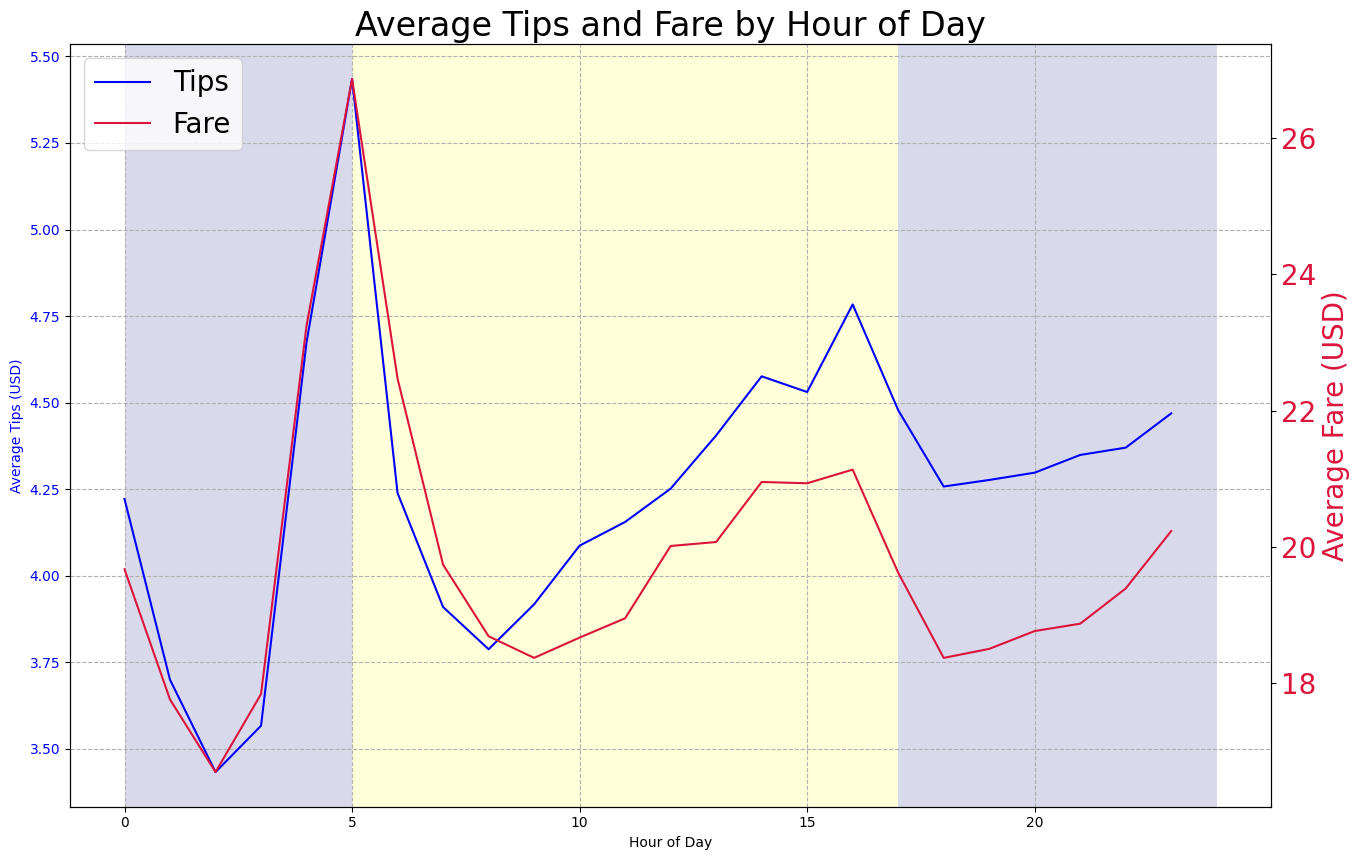

In [10]:
# Plotting the distribution of tips and fare
tips_hourly_stat_pd = tips_hourly_stat.toPandas()
merged_pd = pd.merge(
    tips_hourly_stat_pd,
    hourly_stat_pd,
    on="hour",
    how="inner"
)
fig, ax1 = plt.subplots(figsize=(14, 9))
plt.rcParams.update({"font.size": 20})

# Left y-axis: Tips
ln1 = sns.lineplot(
    x="hour", y="avg_tip_amount", data=merged_pd,
    color="blue", ax=ax1, label="Tips"
)
ax1.set_ylabel("Average Tips (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right y-axis : Fare
ax2 = ax1.twinx()
ln2 = sns.lineplot(
    x="hour", y="avg_fare_amount", data=merged_pd,
    color="crimson", ax=ax2, label="Fare"
)
ax2.set_ylabel("Average Fare (USD)", color="crimson")
ax2.tick_params(axis="y", labelcolor="crimson")

ax1.set_xticks(range(0, 24, 5))
ax1.set_xlabel("Hour of Day")

# Day Night for background
ax1.axvspan(0, 5, facecolor="navy", alpha=0.15)      
ax1.axvspan(5, 17, facecolor="yellow", alpha=0.15)   
ax1.axvspan(17, 24, facecolor="navy", alpha=0.15)    

plt.title("Average Tips and Fare by Hour of Day")
fig.tight_layout()
ax1.grid(True, linestyle="--")

# 👉 Gom legend của cả hai line vào một chỗ
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")
ax2.get_legend().remove()
plt.savefig("plots/tip_fare_by_hour_dual_axis.png", dpi=400, bbox_inches="tight")
plt.show()


In [11]:
# Tips distribution by date using average
taxi_df_tips_date = taxi_df_tips.withColumn("date", col("pickup_datetime").cast("date"))
print("Shape for tips distribution by date:", 
      (taxi_df_tips_date.count(), 
      len(taxi_df_tips_date.columns), 
      taxi_df_tips_date.printSchema()
      )
    )
tips_date_stat = (
    taxi_df_tips_date
    .groupBy("date")
    .agg({"tip_amount": "avg"})
    .withColumnRenamed("avg(tip_amount)", "avg_tip_amount")
    .orderBy("date")
)
print("Shape for tips distribution by date using average:", 
      (tips_date_stat.count(), 
      len(tips_date_stat.columns), 
      tips_date_stat.printSchema()
      )
    )


root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- date: date (nullable = true)

Shape for tips distribution by date: (20887862, 8, None)


root
 |-- date: date (nullable = true)
 |-- avg_tip_amount: double (nullable = true)

Shape for tips distribution by date using average: (242, 2, None)


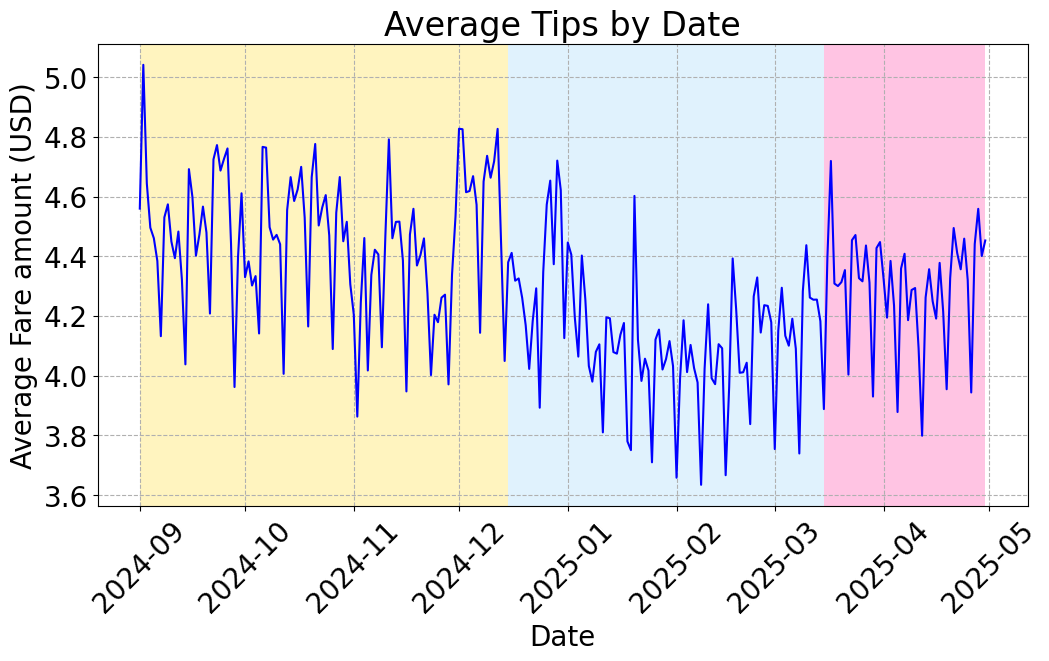

In [ ]:
tips_date_stat_pd = tips_date_stat.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="avg_tip_amount", data=tips_date_stat_pd, color = 'blue')
plt.xticks(rotation=45)

# Highlight background for seasonal patterns 2024 2025
plt.axvspan(datetime(2024, 9, 1), datetime(2024, 12, 15), facecolor="gold", alpha=0.25)  # Autumn
plt.axvspan(datetime(2024, 12, 15), datetime(2025, 3, 15), facecolor="lightskyblue", alpha=0.25)  # Winter
plt.axvspan(datetime(2025, 3, 15), datetime(2025, 4, 30), facecolor="deeppink", alpha=0.25)  # Spring

plt.title("Average Tips by Date")
plt.xlabel("Date")
plt.ylabel("Average Fare amount (USD)")
plt.grid(True, linestyle="--")
plt.savefig("plots/average_tip_by_date.png", dpi=300, bbox_inches="tight")
plt.show()

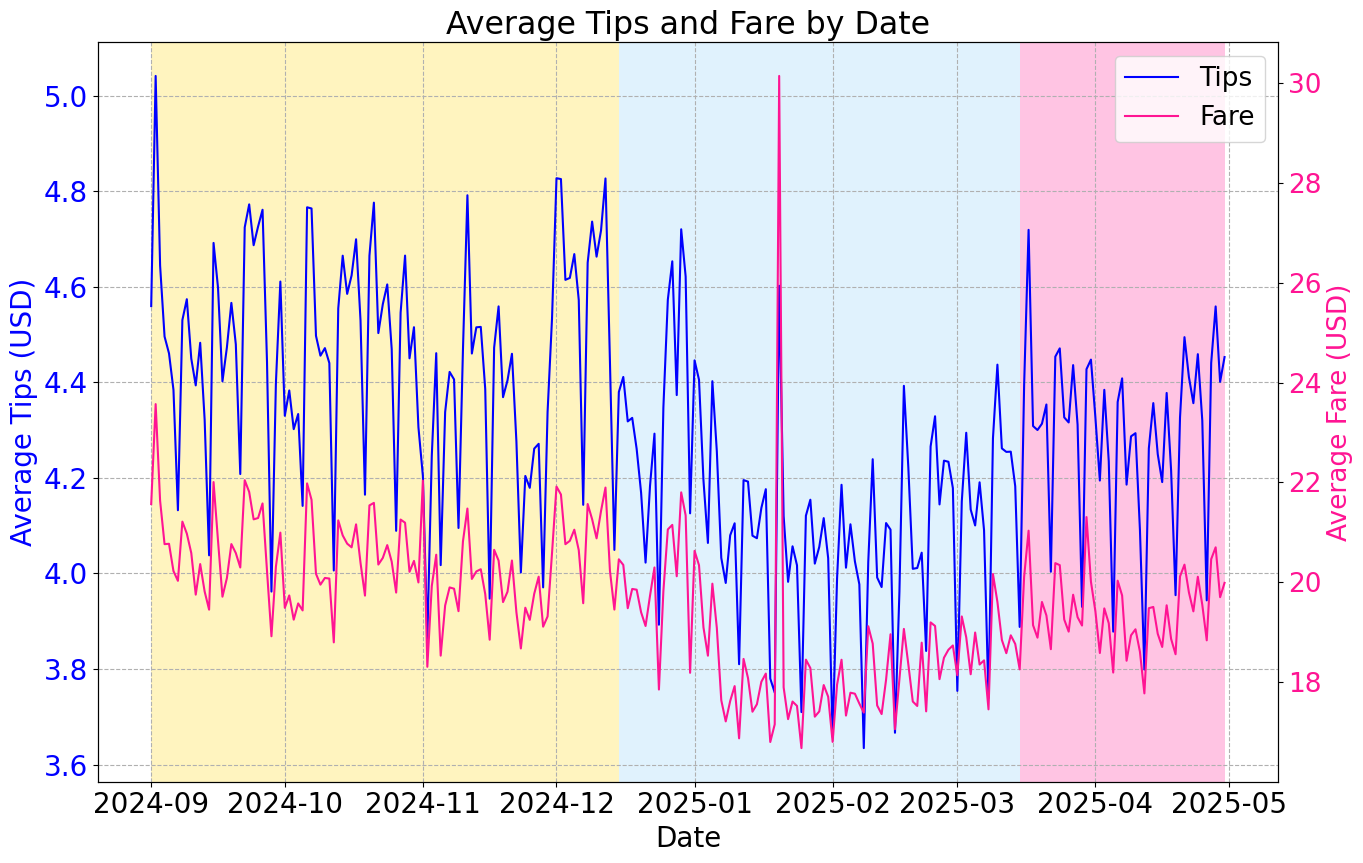

In [12]:
# Convert both Spark DataFrames to Pandas
tips_date_stat_pd = tips_date_stat.toPandas()
fare_date_stat_pd = daily_stat.toPandas()
tips_date_stat_pd["date"] = pd.to_datetime(tips_date_stat_pd["date"])
fare_date_stat_pd["date"] = pd.to_datetime(fare_date_stat_pd["date"])
# Merge on "date"
merged_date_pd = pd.merge(
    tips_date_stat_pd,
    fare_date_stat_pd,
    on="date",
    how="inner"
)

# Dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 9))
plt.rcParams.update({"font.size": 19})

# Left axis: Tips
sns.lineplot(
    x="date", y="avg_tip_amount",
    data=merged_date_pd, color="blue", ax=ax1,
    label="Tips"
)
ax1.set_ylabel("Average Tips (USD)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Right axis: Fare
ax2 = ax1.twinx()
sns.lineplot(
    x="date", y="avg_fare_amount",
    data=merged_date_pd, color="deeppink", ax=ax2,
    label="Fare"
)
ax2.set_ylabel("Average Fare (USD)", color="deeppink")
ax2.tick_params(axis="y", labelcolor="deeppink")

ax1.set_xlabel("Date")

# Highlight background for seasonal patterns 2024–2025
ax1.axvspan(datetime(2024, 9, 1), datetime(2024, 12, 15), facecolor="gold", alpha=0.25)       # Autumn
ax1.axvspan(datetime(2024, 12, 15), datetime(2025, 3, 15), facecolor="lightskyblue", alpha=0.25)  # Winter
ax1.axvspan(datetime(2025, 3, 15), datetime(2025, 4, 30), facecolor="deeppink", alpha=0.25)   # Spring

plt.title("Average Tips and Fare by Date")

fig.tight_layout()
ax1.grid(True, linestyle="--")
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")
ax2.get_legend().remove()
plt.savefig("plots/tip_fare_by_date.png", dpi=400, bbox_inches="tight")
plt.show()


/tmp/ipykernel_12938/2856697674.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


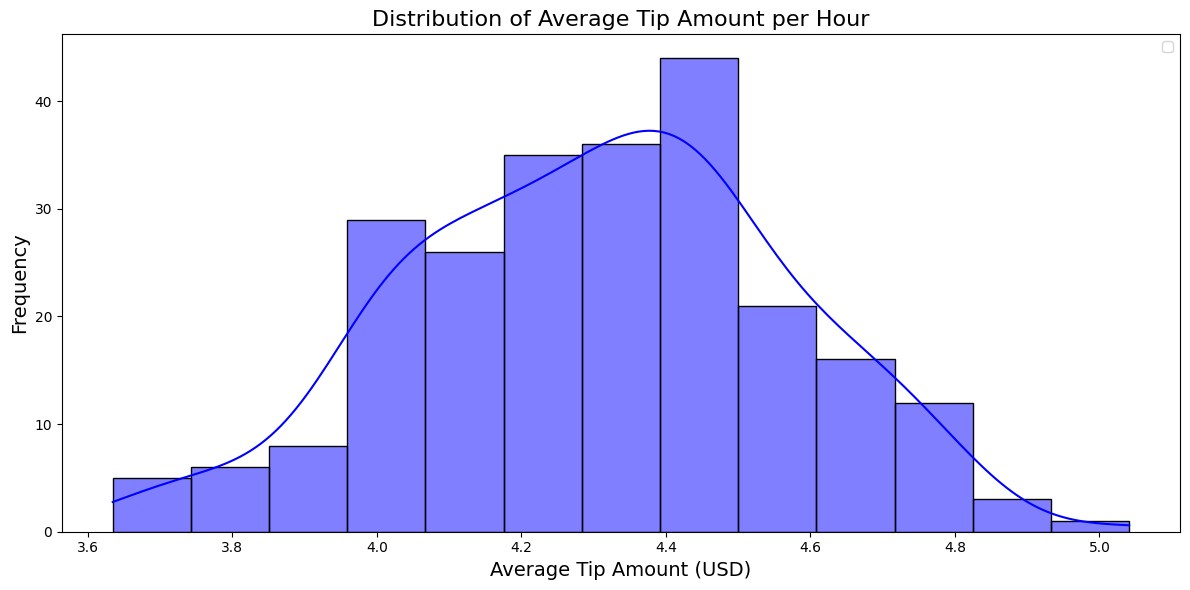

In [15]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(
    tips_date_stat_pd['avg_tip_amount'],
    kde=True,   
    edgecolor='black', 
    color= 'blue'
)

plt.title('Distribution of Average Tip Amount per Hour', fontsize=16)
plt.xlabel('Average Tip Amount (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("plots/average_tip_by_hour_dist.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_12938/936690882.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


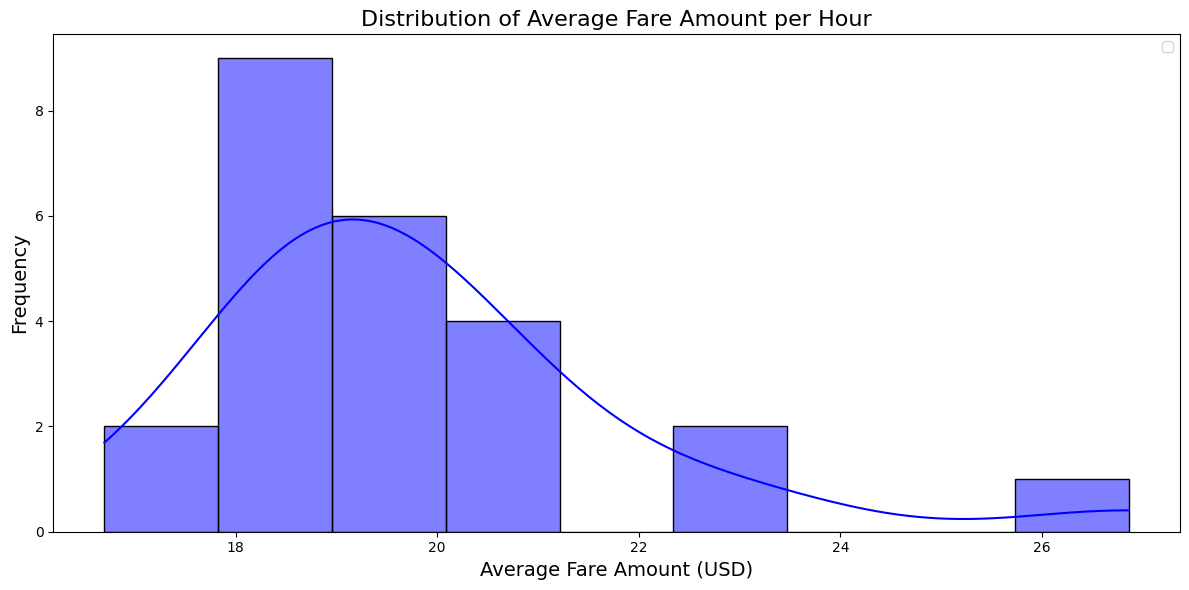

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(
    hourly_stat_pd['avg_fare_amount'],
    kde=True,
    edgecolor='black', 
    color='blue'
)

plt.title('Distribution of Average Fare Amount per Hour', fontsize=16)
plt.xlabel('Average Fare Amount (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("plots/average_fare_by_hour_dist.png", dpi=300, bbox_inches="tight")
plt.show()

### 2. Trend of average taxi income  vs time of the year 
+ Highlight on holiday
+ Using average income of that day

In [13]:
# Adding popular holidays
holidays = {
    "2024-09-02": "Labor Day",
    "2024-09-11": "Patriot Day",
    "2024-10-31": "Halloween",
    "2024-11-11": "Veterans Day",
    "2024-11-28": "Thanksgiving",
    "2024-11-29": "Black Friday",
    "2024-12-24": "Christmas Eve",
    "2024-12-25": "Christmas Day",
    "2024-12-31": "New Year's Eve",
    "2025-01-01": "New Year's Day",
    "2025-02-14": "Valentine's Day",
    "2025-03-17": "St. Patrick's Day",
    "2025-04-01": "April Fool's Day",
    "2025-04-20": "Easter Sunday",
    "2025-04-22": "Earth Day",
}

In [14]:
holiday_df = spark.createDataFrame(
    [(date, name) for date, name in holidays.items()],
    ["date", "name"]
).withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

In [54]:
holiday_df.show()

+----------+-----------------+
|      date|             name|
+----------+-----------------+
|2024-09-02|        Labor Day|
|2024-09-11|      Patriot Day|
|2024-10-31|        Halloween|
|2024-11-11|     Veterans Day|
|2024-11-28|     Thanksgiving|
|2024-11-29|     Black Friday|
|2024-12-24|    Christmas Eve|
|2024-12-25|    Christmas Day|
|2024-12-31|   New Year's Eve|
|2025-01-01|   New Year's Day|
|2025-02-14|  Valentine's Day|
|2025-03-17|St. Patrick's Day|
|2025-04-01| April Fool's Day|
|2025-04-20|    Easter Sunday|
|2025-04-22|        Earth Day|
+----------+-----------------+



In [15]:
# Checking the fare amount and tips on holidays
taxi_df_time = (
    taxi_df
    .withColumn("hour", hour(col("pickup_datetime")))
    .withColumn("pickup_date", to_date(col("pickup_datetime")))
)
taxi_holiday_df = (
    taxi_df_time
    .join(holiday_df,
        taxi_df_time.pickup_date == holiday_df.date, 
        "inner"
        )
)
hourly_holiday_fare = (
    taxi_holiday_df
    .groupBy("name", "hour")
    .agg({"fare_amount": "avg"})
    .withColumnRenamed("avg(fare_amount)", "avg_fare_amount")
    .orderBy("name", "hour")
)

In [16]:
# non holiday
taxi_non_holiday_df = (
    taxi_df_time
    .join(holiday_df,
          taxi_df_time.pickup_date == holiday_df.date,
          "left_anti"
          )
)
hourly_non_holiday_fare = (
    taxi_non_holiday_df
    .groupBy("hour")
    .agg({"fare_amount": "avg"})
    .withColumnRenamed("avg(fare_amount)", "avg_fare_amount")
    .orderBy("hour")
)

In [ ]:
# Graphing the fare amount and tips on holiday
taxi_holiday_df_pd = hourly_holiday_fare.toPandas()
taxi_non_holiday_dp = hourly_non_holiday_fare.toPandas()
taxi_holiday_df_pd['is_holiday'] = 'Holiday'
taxi_non_holiday_dp['is_holiday'] = 'Non-Holiday'
taxi_non_holiday_dp["name"] = "Non-Holiday"
df_combined = pd.concat([taxi_holiday_df_pd, taxi_non_holiday_dp], ignore_index=True)


plt.figure(figsize=(16, 6))
palette = sns.color_palette("bright", n_colors=taxi_holiday_df_pd["name"].nunique())

sns.boxplot(
    data=df_combined,
    x="name", 
    y="avg_fare_amount",
    hue = 'is_holiday',
    palette={'Holiday': 'hotpink', 'Non-Holiday':'gray'}
)

plt.title("Fare Amount on Holidays")
plt.xlabel("Hour of Day")
plt.ylabel("Amount (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [17]:
# Graphing the fare amount and tips on holiday
taxi_holiday_df_pd = hourly_holiday_fare.toPandas()
taxi_non_holiday_dp = hourly_non_holiday_fare.toPandas()
taxi_holiday_df_pd['is_holiday'] = 'Holiday'
taxi_non_holiday_dp['is_holiday'] = 'Non-Holiday'
taxi_non_holiday_dp["name"] = "Non-Holiday"
df_combined = pd.concat([taxi_holiday_df_pd, taxi_non_holiday_dp], ignore_index=True)

In [18]:
# Get list of holidays (excluding Non-Holiday)
holiday_names = df_combined["name"].unique()
holiday_names = [h for h in holiday_names if h != "Non-Holiday"]

In [ ]:
# Create FacetGrid manually to add both lines
g = sns.FacetGrid(
    df_combined[df_combined["name"] != "Non-Holiday"],
    col="name",
    col_wrap=4,
    height=4,
    aspect=1.2
)

# Plot each holiday line and overlay the non-holiday line
for ax, holiday in zip(g.axes.flatten(), holiday_names):
    # Holiday line
    data_h = df_combined[df_combined["name"] == holiday]
    sns.lineplot(data=data_h, x="hour", y="avg_fare_amount", color="hotpink", ax=ax, label=holiday)
    
    # Non-holiday line
    sns.lineplot(data=taxi_non_holiday_dp, x="hour", y="avg_fare_amount", color="gray", ax=ax, label="Non-Holiday")
    
    # Formatting
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(0, 25, 3))
    ax.axvspan(0, 5, facecolor="navy", alpha=0.15)
    ax.axvspan(5, 17, facecolor="yellow", alpha=0.15)
    ax.axvspan(17, 24, facecolor="navy", alpha=0.15)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Fare Amount (USD)")
    ax.set_title(holiday)
    ax.legend()

g.fig.suptitle("Fare Amount Trends by Holiday vs Non-Holiday", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("plots/average_fare_vs_holiday.png", dpi=400, bbox_inches="tight")
plt.show()

In [24]:
from scipy.stats import pearsonr
correlations = {}

# Separate non-holiday tips (by hour)
non_holiday = taxi_non_holiday_dp.set_index('hour')['avg_fare_amount']

for holiday_name in taxi_holiday_df_pd['name'].unique():
    # Select holiday data for this holiday
    holiday_data = taxi_holiday_df_pd[taxi_holiday_df_pd['name'] == holiday_name]
    holiday_series = holiday_data.set_index('hour')['avg_fare_amount']
    
    # Align by hour (inner join) to ensure we compare same hours
    combined = pd.concat([holiday_series, non_holiday], axis=1, join='inner')
    combined.columns = ['holiday', 'non_holiday']
    
    # Calculate Pearson correlation
    corr, _ = pearsonr(combined['holiday'], combined['non_holiday'])
    correlations[holiday_name] = round(corr, 3) 

correlations

{"April Fool's Day": np.float64(-0.055),
 'Black Friday': np.float64(0.876),
 'Christmas Day': np.float64(0.865),
 'Christmas Eve': np.float64(0.657),
 'Earth Day': np.float64(0.472),
 'Easter Sunday': np.float64(0.692),
 'Halloween': np.float64(0.914),
 'Labor Day': np.float64(0.71),
 "New Year's Day": np.float64(0.253),
 "New Year's Eve": np.float64(0.82),
 'Patriot Day': np.float64(0.896),
 "St. Patrick's Day": np.float64(-0.047),
 'Thanksgiving': np.float64(0.924),
 "Valentine's Day": np.float64(0.909),
 'Veterans Day': np.float64(0.69)}

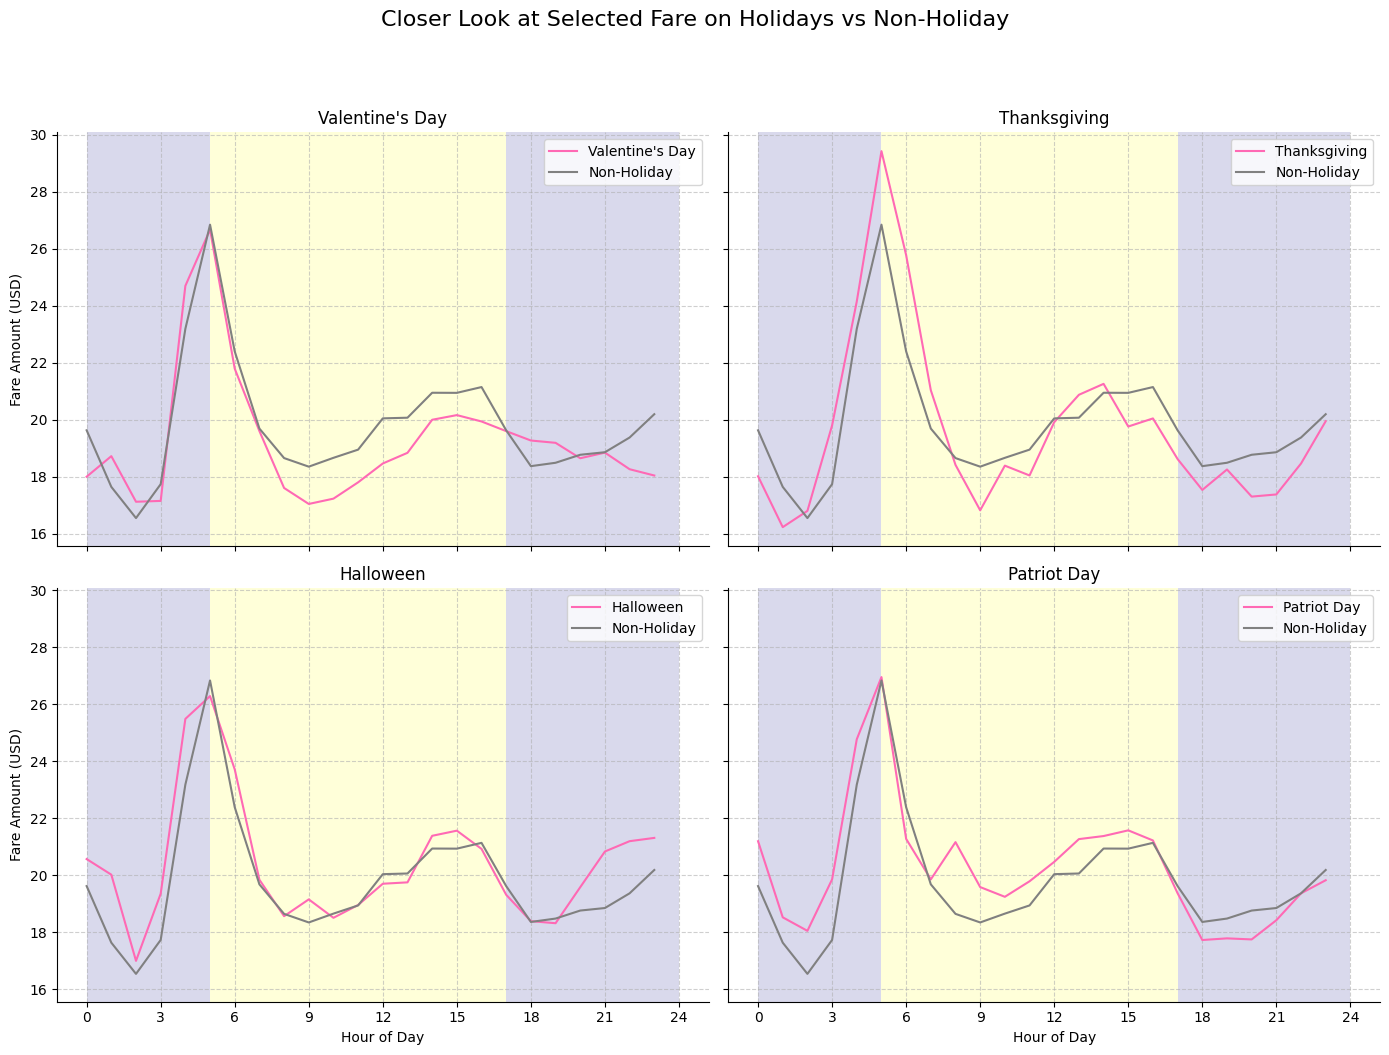

In [46]:
holidays_to_zoom = ["Valentine's Day", "Thanksgiving", "Halloween", "Patriot Day"]

zoom_df = df_combined[df_combined["name"].isin(holidays_to_zoom)]


g = sns.FacetGrid(
    zoom_df,
    col="name",
    col_wrap=2, 
    height=5,   
    aspect=1.4
)

for ax, holiday in zip(g.axes.flatten(), holidays_to_zoom):
    data_h = zoom_df[zoom_df["name"] == holiday]
    # Holiday line
    sns.lineplot(data=data_h, x="hour", y="avg_fare_amount",
                color="hotpink", ax=ax, label=holiday)
    
    # Non-holiday line
    sns.lineplot(data=taxi_non_holiday_dp, x="hour",
                y="avg_fare_amount", color="gray", ax=ax, label="Non-Holiday")
    
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(0, 25, 3))
    ax.axvspan(0, 5, facecolor="navy", alpha=0.15)
    ax.axvspan(5, 17, facecolor="yellow", alpha=0.15)
    ax.axvspan(17, 24, facecolor="navy", alpha=0.15)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Fare Amount (USD)")
    ax.set_title(holiday)
    ax.legend()

g.fig.suptitle("Closer Look at Selected Fare on Holidays vs Non-Holiday", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig("plots/average_fare_vs_selected_holiday.png", dpi=400, bbox_inches="tight")
plt.show()

In [24]:
hourly_holiday_fare.printSchema()

root
 |-- name: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- avg_fare_amount: double (nullable = true)



In [25]:
taxi_holiday_df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- date: date (nullable = true)
 |-- name: string (nullable = true)



In [26]:
taxi_non_holiday_df.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- hour: integer (nullable = true)
 |-- pickup_date: date (nullable = true)



In [19]:
### Analysis on the relationship between holiday and taxi tips
tips_holiday = (
    taxi_holiday_df
    .filter(col("payment_type")==1)
    .groupBy("name", "hour") 
    .agg({"tip_amount": "avg"}) 
    .withColumnRenamed("avg(tip_amount)", "avg_tip_amount")
    .orderBy("name", "hour")
)
tips_non_holiday = (
    taxi_non_holiday_df
    .filter(col("payment_type")==1)
    .groupBy("hour")
    .agg({"tip_amount": "avg"})
    .withColumnRenamed("avg(tip_amount)", "avg_tip_amount")
    .orderBy("hour")
)

print("tips_holiday shape:",(tips_holiday.count(), len(tips_holiday.columns)))
print("tips_non_holiday shape:", (tips_non_holiday.count(), len(tips_non_holiday.columns)))

tips_holiday shape: (360, 3)


tips_non_holiday shape: (24, 2)


In [20]:
holiday_tips = tips_holiday.toPandas()
non_holiday_tips = tips_non_holiday.toPandas()
holiday_tips['is_holiday'] = 'Holiday'
non_holiday_tips['is_holiday'] = 'Non-Holiday'
combine_tips_pd = pd.concat([holiday_tips, non_holiday_tips], ignore_index=True)


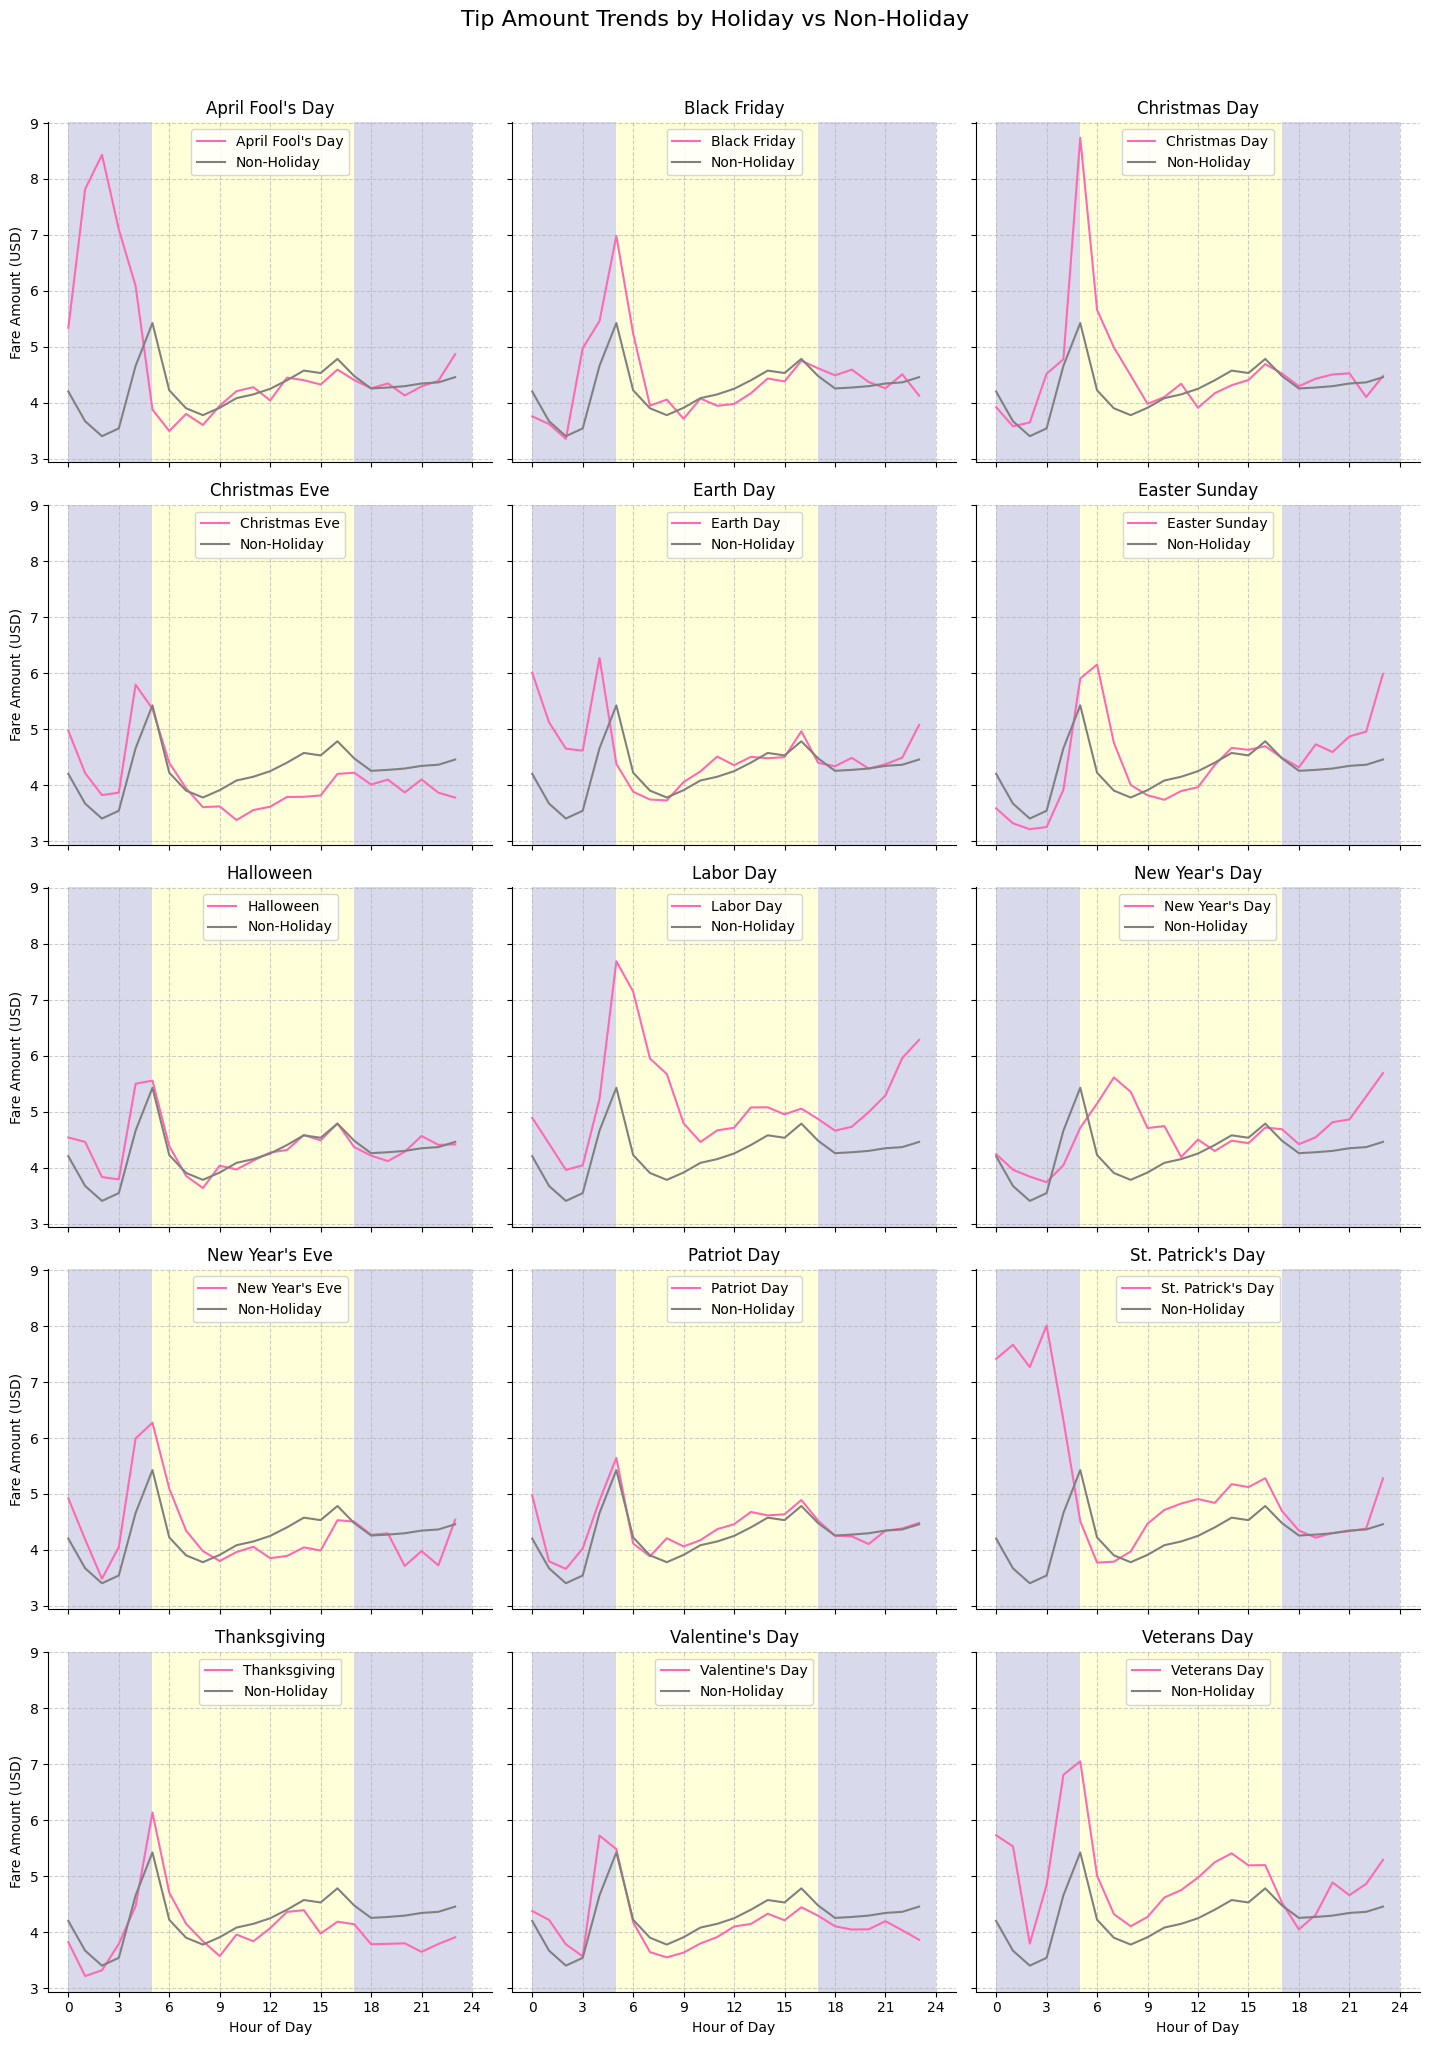

In [32]:
g = sns.FacetGrid(
    combine_tips_pd[combine_tips_pd["name"] != "Non-Holiday"],
    col="name",
    col_wrap=3,
    height=4,
    aspect=1.2
)

# Plot each holiday line and overlay the non-holiday line
for ax, holiday in zip(g.axes.flatten(), holiday_names):
    # Holiday line
    data_h = combine_tips_pd[combine_tips_pd["name"] == holiday]
    sns.lineplot(data=data_h, x="hour", y="avg_tip_amount", color="hotpink", ax=ax, label=holiday)
    
    # Non-holiday line
    sns.lineplot(data=non_holiday_tips, x="hour", y="avg_tip_amount", color="gray", ax=ax, label="Non-Holiday")
    
    # Formatting
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(0, 25, 3))
    ax.axvspan(0, 5, facecolor="navy", alpha=0.15)
    ax.axvspan(5, 17, facecolor="yellow", alpha=0.15)
    ax.axvspan(17, 24, facecolor="navy", alpha=0.15)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Fare Amount (USD)")
    ax.set_title(holiday)
    ax.legend()

g.fig.suptitle("Tip Amount Trends by Holiday vs Non-Holiday", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("plots/average_ftip_vs_holiday.png", dpi=400, bbox_inches="tight")
plt.show()


In [25]:
from scipy.stats import pearsonr
correlations = {}

# Separate non-holiday tips (by hour)
non_holiday = non_holiday_tips.set_index('hour')['avg_tip_amount']

for holiday_name in holiday_tips['name'].unique():
    # Select holiday data for this holiday
    holiday_data = holiday_tips[holiday_tips['name'] == holiday_name]
    holiday_series = holiday_data.set_index('hour')['avg_tip_amount']
    
    # Align by hour (inner join) to ensure we compare same hours
    combined = pd.concat([holiday_series, non_holiday], axis=1, join='inner')
    combined.columns = ['holiday', 'non_holiday']
    
    # Calculate Pearson correlation
    corr, _ = pearsonr(combined['holiday'], combined['non_holiday'])
    correlations[holiday_name] = round(corr, 3)

correlations


{"April Fool's Day": np.float64(-0.494),
 'Black Friday': np.float64(0.716),
 'Christmas Day': np.float64(0.649),
 'Christmas Eve': np.float64(0.504),
 'Earth Day': np.float64(0.186),
 'Easter Sunday': np.float64(0.653),
 'Halloween': np.float64(0.824),
 'Labor Day': np.float64(0.58),
 "New Year's Day": np.float64(0.213),
 "New Year's Eve": np.float64(0.623),
 'Patriot Day': np.float64(0.886),
 "St. Patrick's Day": np.float64(-0.371),
 'Thanksgiving': np.float64(0.77),
 "Valentine's Day": np.float64(0.746),
 'Veterans Day': np.float64(0.671)}

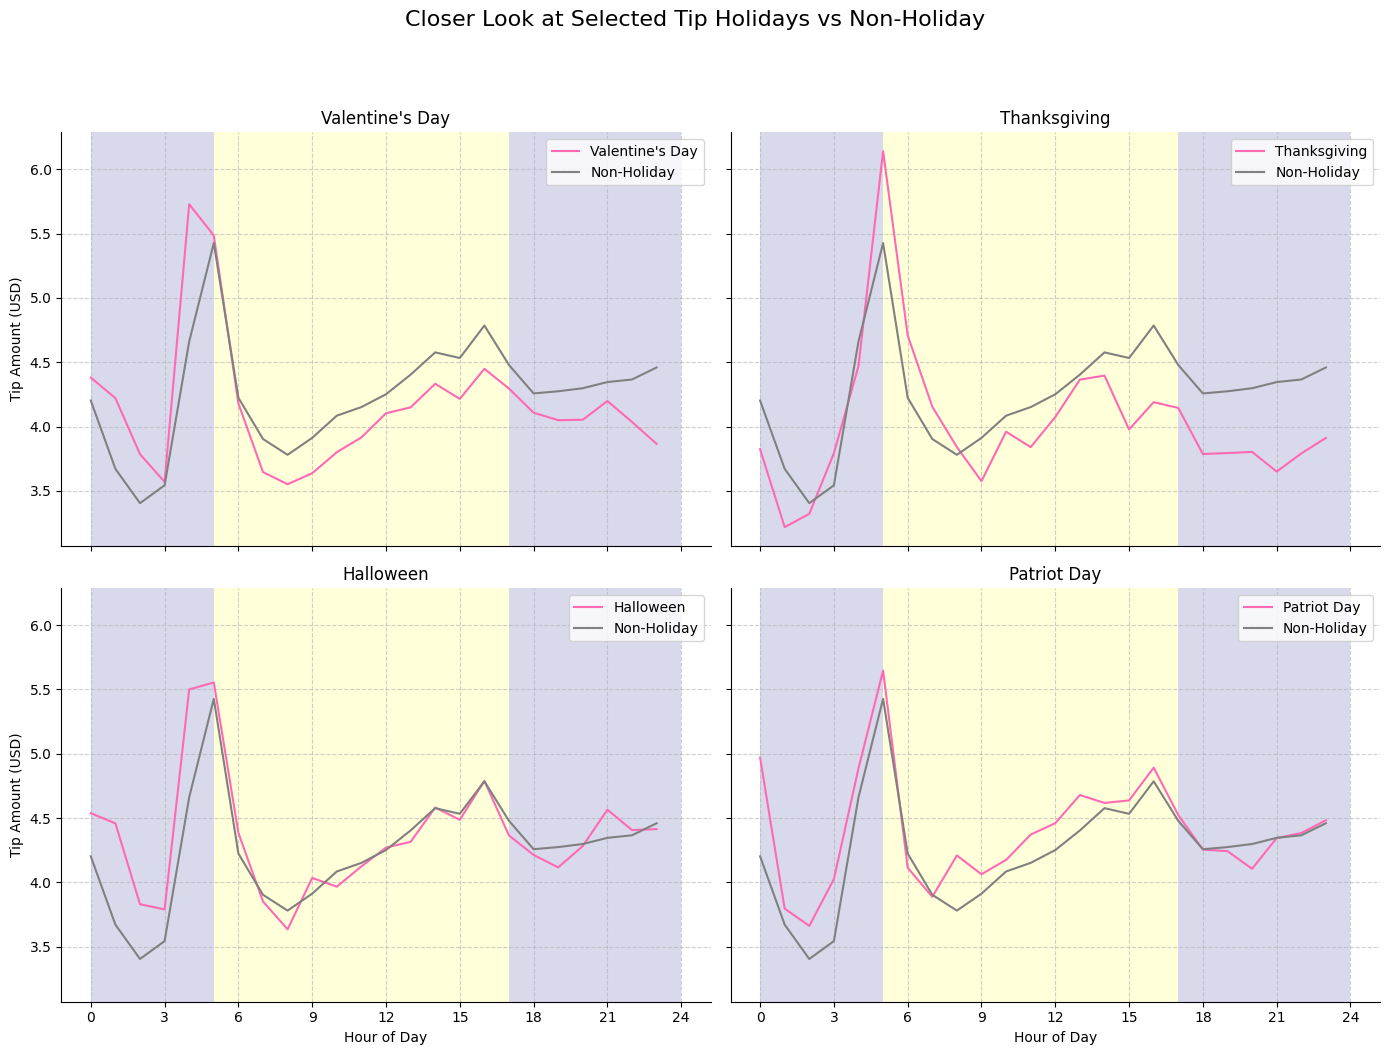

In [45]:
holidays_to_zoom = ["Valentine's Day", "Thanksgiving", "Halloween", "Patriot Day"]

zoom_df = combine_tips_pd[combine_tips_pd["name"].isin(holidays_to_zoom)]


g = sns.FacetGrid(
    zoom_df,
    col="name",
    col_wrap=2, 
    height=5,   
    aspect=1.4
)

for ax, holiday in zip(g.axes.flatten(), holidays_to_zoom):
    data_h = zoom_df[zoom_df["name"] == holiday]
    # Holiday line
    sns.lineplot(data=data_h, x="hour", y="avg_tip_amount",
                color="hotpink", ax=ax, label=holiday)
    
    # Non-holiday line
    sns.lineplot(data=non_holiday_tips, x="hour",
                y="avg_tip_amount", color="gray", ax=ax, label="Non-Holiday")
    
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(range(0, 25, 3))
    ax.axvspan(0, 5, facecolor="navy", alpha=0.15)
    ax.axvspan(5, 17, facecolor="yellow", alpha=0.15)
    ax.axvspan(17, 24, facecolor="navy", alpha=0.15)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Tip Amount (USD)")
    ax.set_title(holiday)
    ax.legend()

g.fig.suptitle("Closer Look at Selected Tip Holidays vs Non-Holiday", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig("plots/average_tip_vs_selected_holiday.png", dpi=400, bbox_inches="tight")
plt.show()

In [30]:
taxi_holiday_df = (
    taxi_holiday_df
    .withColumn(
        "name",
        F.when(
            F.col("name").isin(
                "Valentine", "Thanks Giving", "Halloween", "Patriot Day"
            ),
            F.lit("NA"),
        ).otherwise(F.col("name"))
    )
)
print(
    "Shape after replacing certain holiday names:",
    (taxi_holiday_df.count(), len(taxi_holiday_df.columns))
)

Shape after replacing certain holiday names: (1460436, 11)


In [31]:
taxi_non_holiday_df = taxi_non_holiday_df.withColumn("name", F.lit("NA"))

print(
    "Shape after setting non-holiday names to NA:",
    (taxi_non_holiday_df.count(), len(taxi_non_holiday_df.columns))
)

Shape after setting non-holiday names to NA: (27048521, 10)


In [32]:
taxi_holiday_df.write.mode("overwrite").parquet("data/training/taxi_on_holiday.parquet")
taxi_non_holiday_df.write.mode("overwrite").parquet("data/training/taxi_on_non_holiday.parquet")

### 3. Effect of precipitation on tips and income


In [26]:
from pyspark.sql.functions import col, to_date


In [27]:
# importing weather data
weather_df = spark.read.parquet('data/processed_data/processed_weather_data.parquet')

In [35]:
weather_df.filter(col("air_pressure") == 9999.9).count()

1671

In [46]:
# Cleaning the data further to match the taxi data
from pyspark.sql import functions as F
from pyspark.sql.functions import hour, col
weather_df_cleaned = (
    weather_df
    .withColumn(
        "air_pressure",
        F.when(col("air_pressure") == 9999.9, None).otherwise(col("air_pressure"))
    )
    .dropna(subset=["air_pressure"])
    .withColumn("date", to_date(col("timestamp")))
    .withColumn("hour", hour(col("timestamp")))
)




In [47]:
print(
    "Shape after cleaning weather data:",
    (weather_df_cleaned.count(), len(weather_df_cleaned.columns))
)

Shape after cleaning weather data: (5520, 9)


In [48]:
from pyspark.sql.functions import when

weather_df_cleaned_2 = (
    weather_df_cleaned
    .withColumn("hour", hour(col("time")))
    .groupBy("date", "hour")
    .agg(
        F.avg("air_temp_celsius").alias("avg_air_temperature"),
        F.avg("air_pressure").alias("avg_air_pressure"),
        F.avg("dew_point_celsius").alias("avg_dew_point"),
        F.avg("precip_mm").alias("avg_precipitation"),
    )
    .withColumn(
        "precip_happened",
        when(col("avg_precipitation") > 0, "Yes").otherwise("No"),
    )
)


In [49]:
print(
    "Shape after weather hourly aggregation:",
    (weather_df_cleaned_2.count(), len(weather_df_cleaned_2.columns))
)


Shape after weather hourly aggregation: (5519, 7)


In [50]:
# Plot tips_hourly_stat_pd on the weather data 
# Add hour and date columns
taxi_df_tips_time = (
    taxi_df_tips
    .withColumn("hour", hour(col("pickup_datetime")))
    .withColumn("date", col("pickup_datetime").cast("date"))
)

# Aggregate average tip by date + hour
tips_hourly_stat = (
    taxi_df_tips_time
    .groupBy("date", "hour")
    .agg(F.avg("tip_amount").alias("avg_tip_amount"))
    .orderBy("date", "hour")
)

# Join with weather
tips_on_weather = (
    tips_hourly_stat
    .join(
        weather_df_cleaned_2,
        on=[
            tips_hourly_stat.date == weather_df_cleaned_2.date,
            tips_hourly_stat.hour == weather_df_cleaned_2.hour,
        ],
        how="left",
    )
    .drop(weather_df_cleaned_2.date, weather_df_cleaned_2.hour)
    .fillna({"avg_tip_amount": 0.0})
)



In [51]:
print(
    "Shape after joining tips with weather:",
    (tips_on_weather.count(), len(tips_on_weather.columns))
)

Shape after joining tips with weather: (5807, 8)


In [52]:
from pyspark.sql.functions import col
# there was some invalid dew point data in the set
tips_on_weather = (
    tips_on_weather
    .filter(col("avg_dew_point") < 999)
)

In [53]:
print("tip_on_weather_filtered shape:",
       tips_on_weather.count(),
    len(tips_on_weather.columns)
    )

tip_on_weather_filtered shape: 5517 8


/tmp/ipykernel_27714/1625199288.py:5: FutureWarning:                            

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


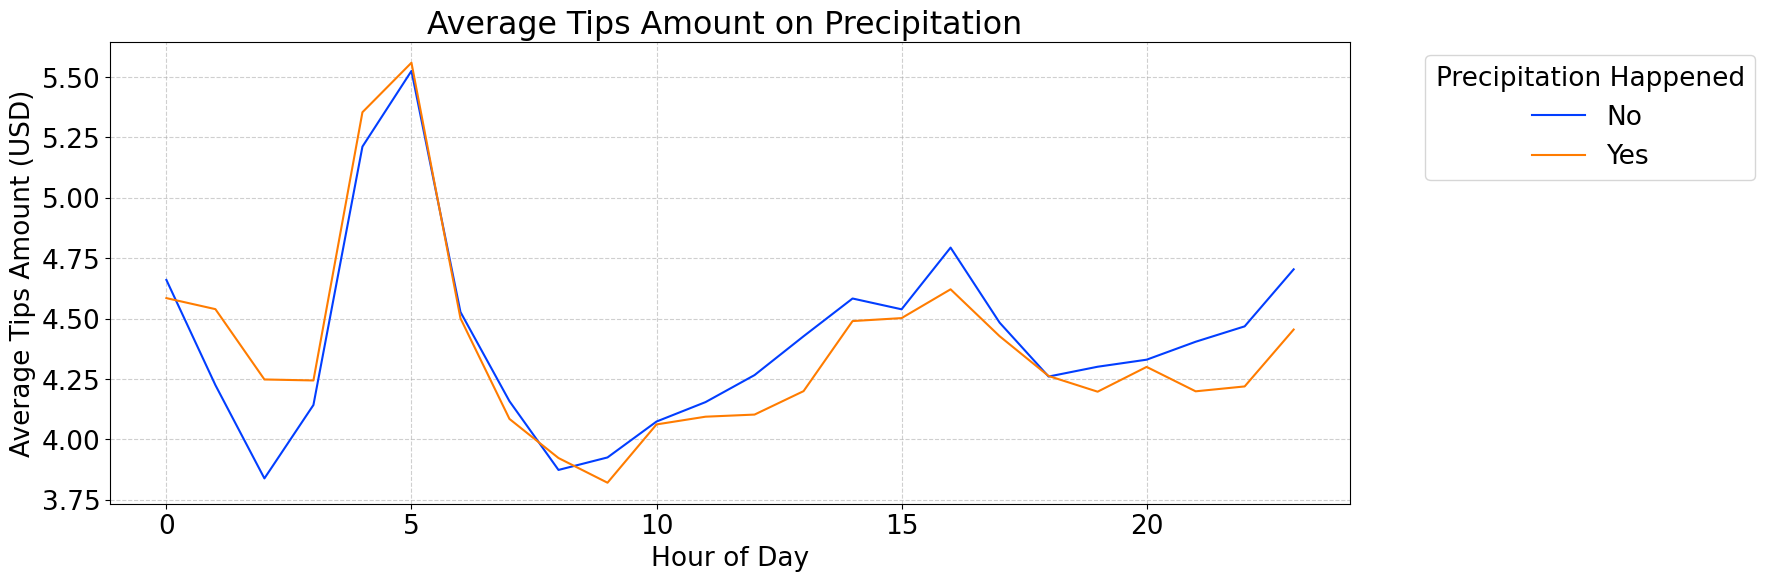

In [54]:
# Plot tips_on_weather
tips_on_weather_pd = tips_on_weather.toPandas()
plt.figure(figsize=(16, 6))
palette = sns.color_palette("bright", n_colors=tips_on_weather_pd["precip_happened"].nunique())
sns.lineplot(
    data=tips_on_weather_pd,
    x="hour", 
    y="avg_tip_amount",
    hue="precip_happened",
    palette=palette,
    ci= None
)
plt.title("Average Tips Amount on Precipitation ")
plt.xlabel("Hour of Day")
plt.ylabel("Average Tips Amount (USD)")
plt.legend(title="Precipitation Happened", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_tip_vs_precip.png", dpi=300, bbox_inches="tight")
plt.show()

In [55]:
tips_on_weather_pd.head(5)

,date,hour,avg_tip_amount,avg_air_temperature,avg_air_pressure,avg_dew_point,avg_precipitation,precip_happened
0,2025-03-13,2,4.056361,6.7,1017.6,-0.6,0.0,No
1,2025-03-21,2,6.437293,9.4,1000.1,8.3,7.9,Yes
2,2025-03-23,17,4.873990,6.1,1021.0,-13.3,0.0,No
3,2025-03-26,5,5.069342,10.0,1014.4,-6.1,NaN,No
4,2025-03-30,18,4.394180,7.8,1019.3,4.4,0.0,No


In [56]:
tips_on_weather.filter(col("hour") != 0).show(5, truncate=False)

+----------+----+-----------------+-------------------+----------------+-------------+-----------------+---------------+
|date      |hour|avg_tip_amount   |avg_air_temperature|avg_air_pressure|avg_dew_point|avg_precipitation|precip_happened|
+----------+----+-----------------+-------------------+----------------+-------------+-----------------+---------------+
|2025-03-13|2   |4.056360759493668|6.7                |1017.6          |-0.6         |0.0              |No             |
|2025-03-21|2   |6.437293064876961|9.4                |1000.1          |8.3          |7.9              |Yes            |
|2025-03-23|17  |4.873989547038331|6.1                |1021.0          |-13.3        |0.0              |No             |
|2025-03-26|5   |5.069341825902338|10.0               |1014.4          |-6.1         |NULL             |No             |
|2025-03-30|18  |4.394180154820551|7.8                |1019.3          |4.4          |0.0              |No             |
+----------+----+---------------

In [57]:
tips_on_weather_pd.head(5)

,date,hour,avg_tip_amount,avg_air_temperature,avg_air_pressure,avg_dew_point,avg_precipitation,precip_happened
0,2025-03-13,2,4.056361,6.7,1017.6,-0.6,0.0,No
1,2025-03-21,2,6.437293,9.4,1000.1,8.3,7.9,Yes
2,2025-03-23,17,4.873990,6.1,1021.0,-13.3,0.0,No
3,2025-03-26,5,5.069342,10.0,1014.4,-6.1,NaN,No
4,2025-03-30,18,4.394180,7.8,1019.3,4.4,0.0,No


In [58]:
# Plot fate_hourly_stat_pd on the weather data 

# Add hour and date columns
taxi_df_fare_time = (
    taxi_df_date
    .withColumn("hour", hour(col("pickup_datetime")))
    .withColumn("date", col("pickup_datetime").cast("date"))
)
print(
    "Shape after adding hour and date columns:",
    (taxi_df_fare_time.count(), len(taxi_df_fare_time.columns))
)

# Aggregate average fare by date + hour
fare_hourly_stat = (
    taxi_df_fare_time
    .groupBy("date", "hour")
    .agg(F.avg("fare_amount").alias("avg_fare_amount"))
    .orderBy("date", "hour")
)
print(
    "Shape after hourly fare aggregation:",
    (fare_hourly_stat.count(), len(fare_hourly_stat.columns))
)

# Compute global average fare for filling missing values
global_avg_fare = fare_hourly_stat.agg(F.avg("avg_fare_amount")).first()[0]
print("Global average fare:", global_avg_fare)

# Join with weather data
fare_on_weather = (
    fare_hourly_stat
    .join(
        weather_df_cleaned_2,
        on=[
            fare_hourly_stat.date == weather_df_cleaned_2.date,
            fare_hourly_stat.hour == weather_df_cleaned_2.hour,
        ],
        how="outer",
    )
)
print(
    "Shape after joining with weather data (before drop/fillna):",
    (fare_on_weather.count(), len(fare_on_weather.columns))
)

# Drop duplicate join columns and fill missing fare values
fare_on_weather = fare_on_weather.drop(
    weather_df_cleaned_2.date, weather_df_cleaned_2.hour
).fillna({"avg_fare_amount": global_avg_fare})
print(
    "Shape after dropping extra columns and filling missing fares:",
    (fare_on_weather.count(), len(fare_on_weather.columns))
)


Shape after adding hour and date columns: (28508957, 9)


Shape after hourly fare aggregation: (5807, 3)


Global average fare: 20.400557820598916


Shape after joining with weather data (before drop/fillna): (5808, 10)


Shape after dropping extra columns and filling missing fares: (5808, 8)


In [59]:
# there was some invalid dew point data in the set
fare_on_weather = (
    fare_on_weather
    .filter(col("avg_dew_point") < 999)
)
print("tip_on_weather_filtered shape:",
       fare_on_weather.count(),
    len(fare_on_weather.columns)
    )


tip_on_weather_filtered shape: 5518 8


/tmp/ipykernel_27714/3693344831.py:6: FutureWarning:                            

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


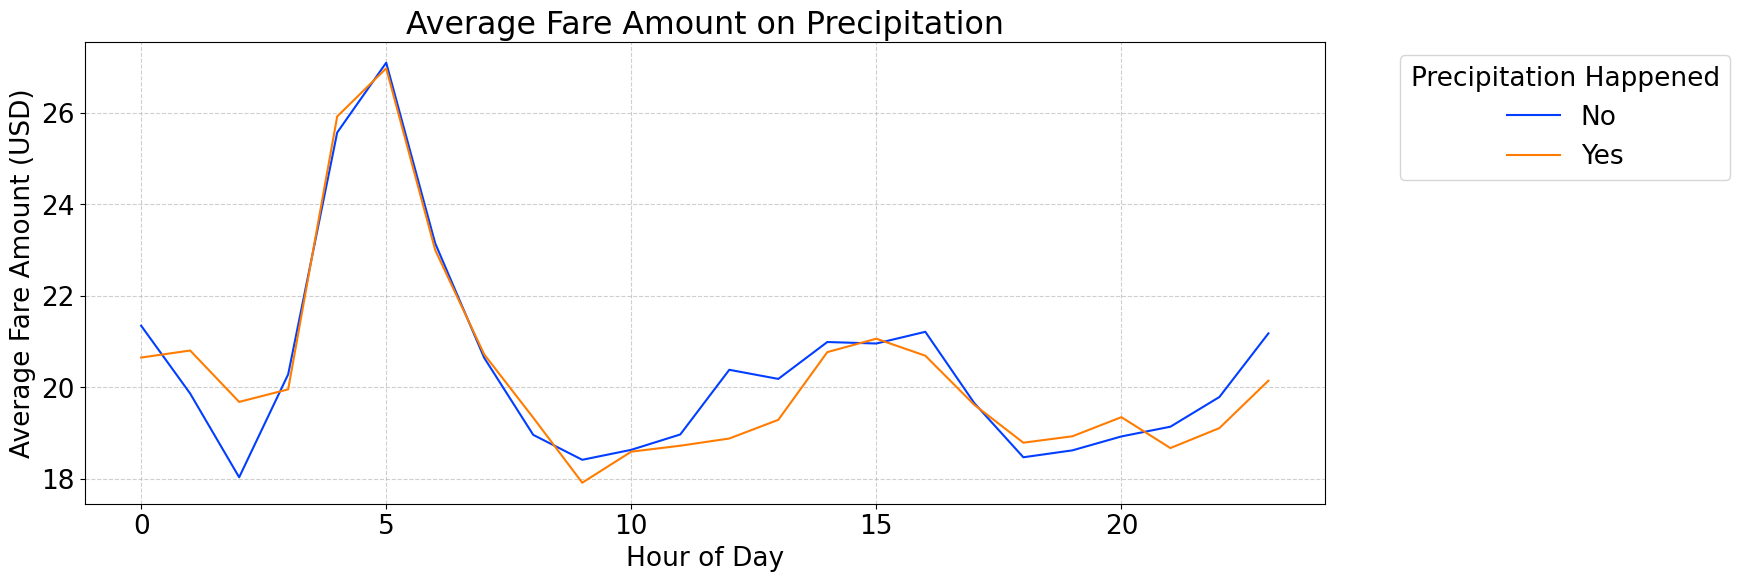

In [60]:
# Plot fare against weather conditions

fare_on_weather_pd = fare_on_weather.toPandas()
plt.figure(figsize=(16, 6))
palette = sns.color_palette("bright", n_colors=fare_on_weather_pd["precip_happened"].nunique())
sns.lineplot(
    data=fare_on_weather_pd,
    x="hour", 
    y="avg_fare_amount",
    hue="precip_happened",
    palette=palette,
    ci= None
)
plt.title("Average Fare Amount on Precipitation")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare Amount (USD)")
plt.legend(title="Precipitation Happened", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_fare_on_precip.png", dpi=300, bbox_inches="tight")
plt.show()

### 4. The other weather data on tips and fare

In [61]:
fare_on_weather_pd.head()

,date,hour,avg_fare_amount,avg_air_temperature,avg_air_pressure,avg_dew_point,avg_precipitation,precip_happened
0,2025-01-02,17.0,19.407950,5.6,1012.4,-7.8,0.0,No
1,2025-02-17,21.0,20.084380,0.6,1011.0,-15.0,0.0,No
2,2025-03-13,2.0,17.584947,6.7,1017.6,-0.6,0.0,No
3,2025-03-21,2.0,29.889193,9.4,1000.1,8.3,7.9,Yes
4,2025-03-23,17.0,22.183055,6.1,1021.0,-13.3,0.0,No


/tmp/ipykernel_27714/3509475073.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/3509475073.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/3509475073.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/3509475073.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


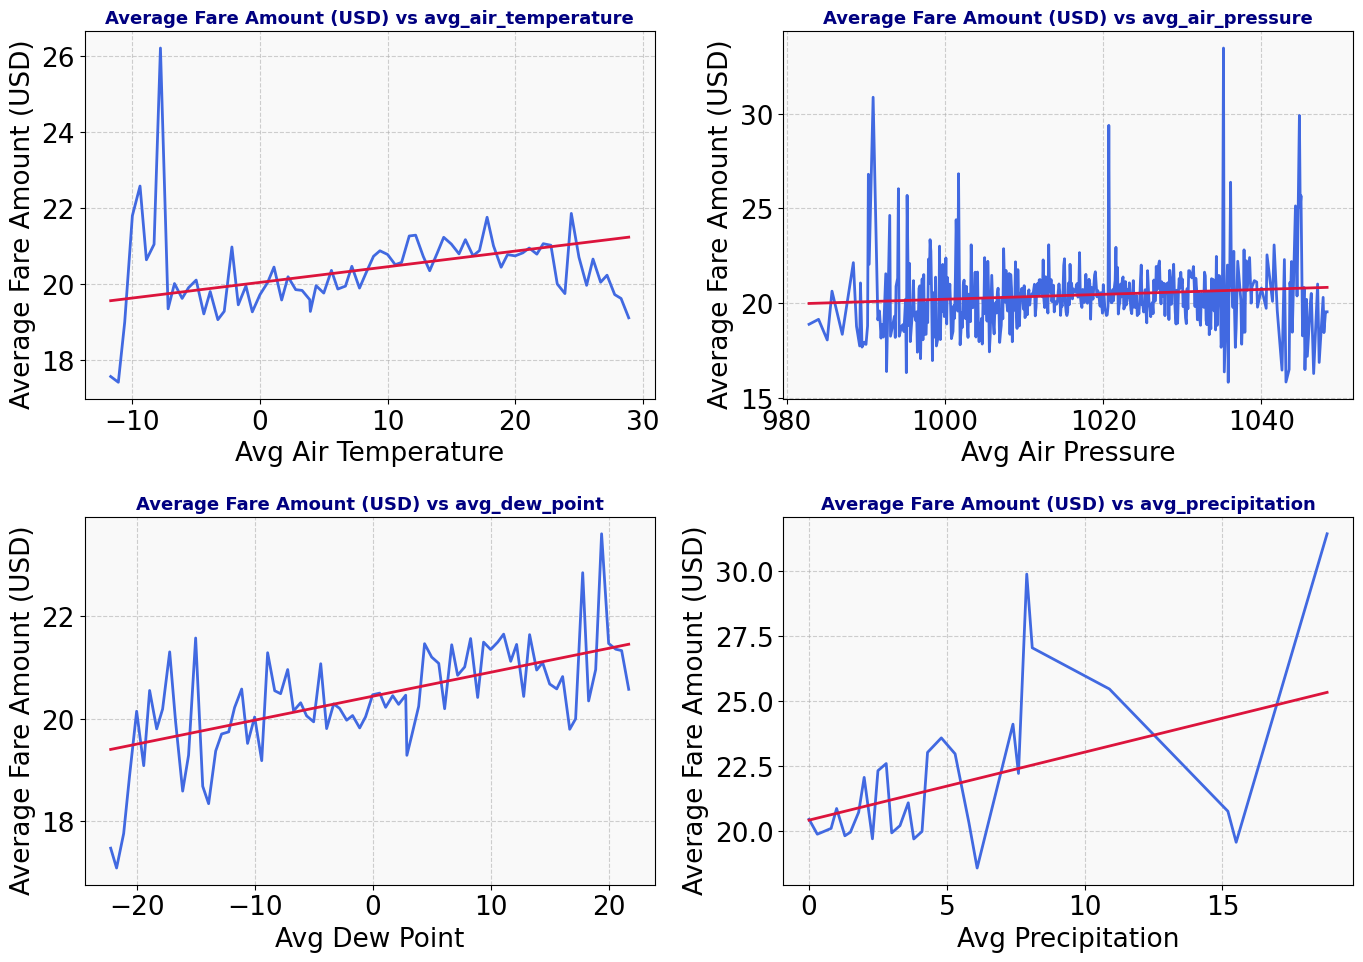

In [69]:
COLS = ["avg_air_temperature", "avg_air_pressure", "avg_dew_point", "avg_precipitation"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.rcParams.update({"font.size": 19})
axes = axes.flatten()  # flatten so we can loop easily

for i, col in enumerate(COLS):
    ax = axes[i]

    sns.lineplot(
        data=fare_on_weather_pd.sort_values(col),  # sort so lines are nice
        x=col,
        y="avg_fare_amount",
        linewidth=2,
        color="royalblue",
        ax=ax,
        ci = None
    )

    # Regression line
    sns.regplot(
        data=fare_on_weather_pd,
        x=col,
        y="avg_fare_amount",
        scatter=False,
        color="crimson",
        line_kws={"linewidth": 2},
        ci=None,
        ax=ax
    )

    ax.set_title(f"Average Fare Amount (USD) vs {col}",fontsize= 13, weight="bold", color="navy")
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel("Average Fare Amount (USD)  ")

    ax.set_facecolor("#f9f9f9")
    ax.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_fare_vs_weather.png", dpi=500, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [63]:
fare_on_weather = fare_on_weather.drop(
    "avg_air_temperature","avg_air_pressure","precip_happened"
)

print(
    "Shape after dropping some features:",
    (fare_on_weather.count(), len(fare_on_weather.columns))
)


Shape after dropping some features: (5518, 5)


In [64]:
fare_on_weather.write.mode("overwrite").parquet("data/training/fare_and_weather.parquet")

/tmp/ipykernel_27714/4046449537.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/4046449537.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/4046449537.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_27714/4046449537.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


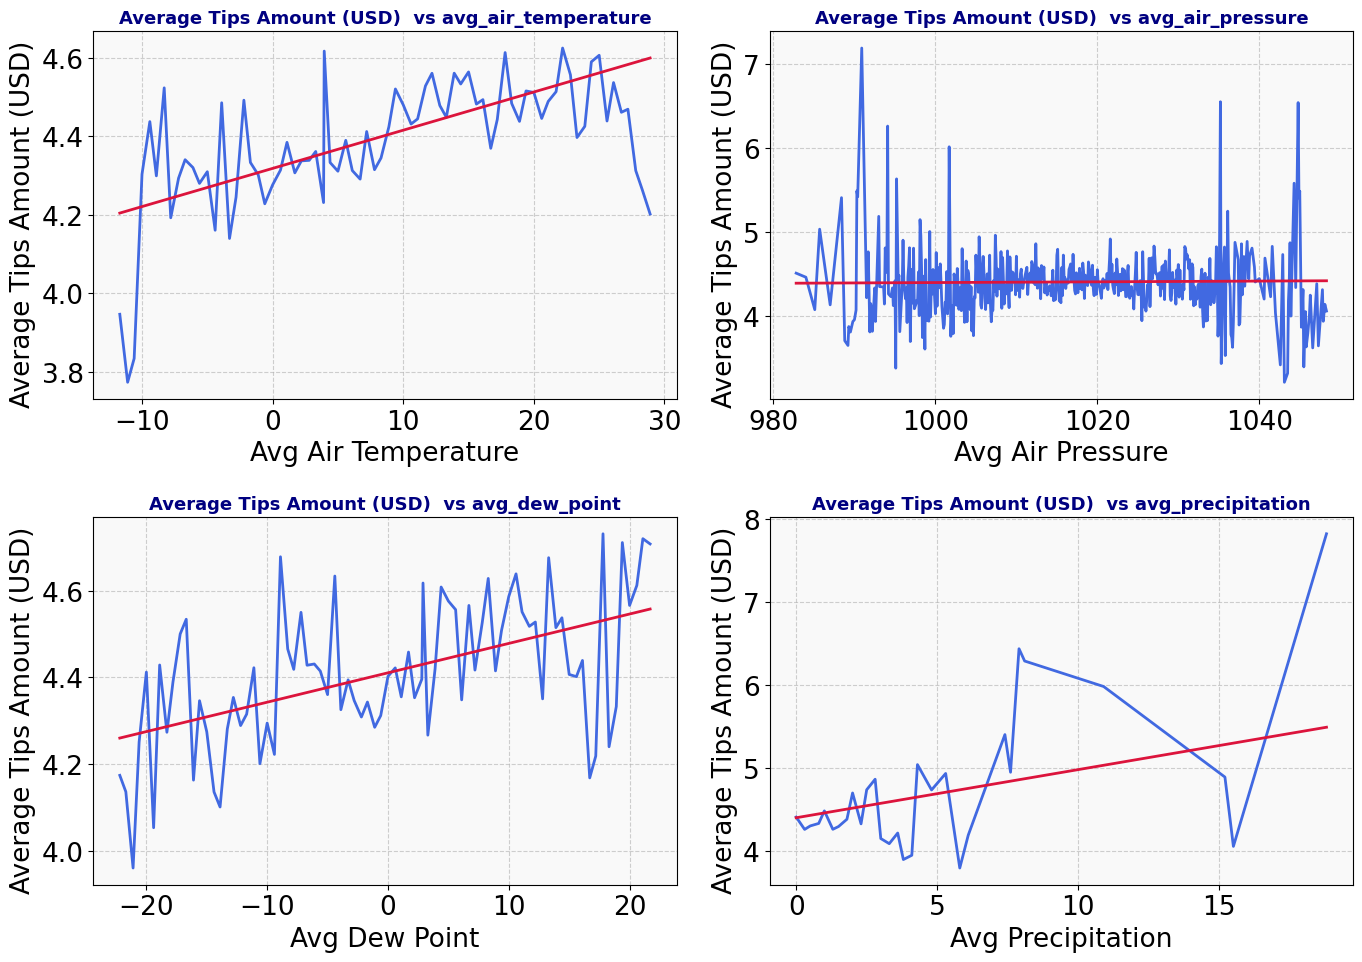

In [71]:
# tips on weather
COLS = ["avg_air_temperature", "avg_air_pressure", "avg_dew_point", "avg_precipitation"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten so we can loop easily

for i, col in enumerate(COLS):
    ax = axes[i]

    sns.lineplot(
        data=tips_on_weather_pd.sort_values(col),  # sort so lines are nice
        x=col,
        y="avg_tip_amount",
        linewidth=2,
        color="royalblue",
        ax=ax,
        ci = None
    )

    # Regression line
    sns.regplot(
        data=tips_on_weather_pd,
        x=col,
        y="avg_tip_amount",
        scatter=False,
        color="crimson",
        line_kws={"linewidth": 2},
        ci=None,
        ax=ax
    )

    ax.set_title(f"Average Tips Amount (USD)  vs {col}", fontsize=13, weight="bold", color="navy")
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel("Average Tips Amount (USD)  ")

    ax.set_facecolor("#f9f9f9")
    ax.grid(True, linestyle="--", alpha=0.6)
plt.savefig("plots/average_tip_vs_weather.png", dpi=500, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [66]:
tips_on_weather = tips_on_weather.drop(
    "avg_air_pressure","precip_happened"
)

print(
    "Shape after dropping some features:",
    (tips_on_weather.count(), len(tips_on_weather.columns))
)

Shape after dropping some features: (5517, 6)


In [67]:
tips_on_weather.write.mode("overwrite").parquet("data/training/tips_and_weather.parquet")

Checking :
we don't see the different between percipitation and no precipitation so we don't use it, check on holiday as well as other weather pattern. Focusing on tips